# Load model

In [1]:
import numpy as np
import torch
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
# If GPUs available, select which to train on
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from utils import generate_run_ID, load_trained_weights
from place_cells import PlaceCells
from trajectory_generator import TrajectoryGenerator
from model import RNN
from trainer import Trainer

In [4]:
# Training options and hyperparameters
class Options:
    pass
options = Options()

options.save_dir = './models'
options.n_steps = 1000      # number of training steps
options.batch_size = 200      # number of trajectories per batch
options.sequence_length = 20  # number of steps in trajectory
options.learning_rate = 1e-4  # gradient descent learning rate #np.sqrt(90 / 20)*
options.Np = 512              # number of place cells
options.Ng = 4096          # number of grid cells
options.place_cell_rf = 0.12  # width of place cell center tuning curve (m)
options.surround_scale = 2    # if DoG, ratio of sigma2^2 to sigma1^2
options.RNN_type = 'RNN'      # RNN, RNN_2RNN or RNN_reconstruction
options.activation = 'relu'   # recurrent nonlinearity
options.weight_decay = 1e-4   # strength of weight decay on recurrent weights
options.DoG = True            # use difference of gaussians tuning curves
options.periodic = False       # trajectories with periodic boundary conditions
options.box_width = 2.2       # width of training environment (m)
options.box_height = 2.2      # height of training environment (m)
options.seed = None           # random seed 

options.run_ID = generate_run_ID(options)
options.device = torch.device('cpu')

In [5]:
# If you've trained with these params before, will restore trained model
place_cells = PlaceCells(options)
model = RNN(options, place_cells)
trajectory_generator = TrajectoryGenerator(options, place_cells)
trainer = Trainer(options, model, trajectory_generator)

Initializing new model from scratch.
Saving to: ./models/steps_20_batch_200_RNN_4096_relu_rf_012_DoG_True_periodic_False_lr_00001_weight_decay_00001


In [6]:
# Load example weights stored on github
weight_dir = options.save_dir + '/example_trained_weights.npy'
load_trained_weights(model, trainer, weight_dir)

Initialized trained weights.
Epoch: 0/1. Step 0/1. Loss: 6.37. Err: 93.94cm
Loaded trained weights.
Epoch: 0/1. Step 0/1. Loss: 6.16. Err: 4.68cm


# isomap

In [7]:
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

scaler = StandardScaler()

In [8]:
# set random seed
seed = 19
np.random.seed(seed)

In [9]:
# Load data
os.chdir('./models/steps_20_batch_200_RNN_4096_relu_rf_012_DoG_True_periodic_False_lr_00001_weight_decay_00001/data')
L = np.load('L.npy')
theta = np.load('orientation.npy')
band_score = np.load('band_score.npy')

In [10]:
# high band score cells
score_thres = 5.8
high_band_idxs = np.argsort(band_score)[::-1][0:len(np.where(band_score > 5.8)[0])]

# threshold for spacing and orientation to extract modules
L_1_theta_1 = np.where((L < 0.625) & (theta < 80))[0]
L_1_theta_2 = np.where((L < 0.7) & (theta > 120))[0]
L_2_theta_3 = np.where((L > 0.85) & (theta > 80) & (theta < 130))[0]
L_2_theta_2 = np.where((L > 0.875) & (theta > 130))[0]

# take the intersection with high_band_idxs
L_1_theta_2 = np.intersect1d(L_1_theta_2, high_band_idxs)
L_1_theta_1 = np.intersect1d(L_1_theta_1, high_band_idxs)
L_2_theta_3 = np.intersect1d(L_2_theta_3, high_band_idxs)
L_2_theta_2 = np.intersect1d(L_2_theta_2, high_band_idxs)

index = L_1_theta_2

Generate movement trajectories and electrophysiological data

In [11]:
# trajectory: Motion trajectory data with shape (sequence_length, batch_size, 2) (x, y coordinates)
# neural_data: Electrophysiological data matrix with shape (sequence_length, batch_size, n_neurons)
inputs, pos, pc_outputs, theta = trajectory_generator.get_test_batch(batch_size = 200)
g_batch = model.g(inputs).detach().cpu().numpy()

# Select the corresponding index
neural_data = g_batch[:, :, index]  # (sequence_length, batch_size, 2)
trajectory = pos  # (sequence_length, batch_size, 2)

# Data Standardization
neural_data = neural_data.reshape(-1, neural_data.shape[-1])
neural_data_scaled = scaler.fit_transform(neural_data)

In [12]:
# First use PCA to reduce the dimensionality to 15 (to reduce computational load)
pca = PCA(n_components=15)
neural_pca = pca.fit_transform(neural_data_scaled)

# Use Isomap for dimensionality reduction
n_components = 3  # Reduced dimensions
n_neighbors = 8   # Isomap's number of neighbors

isomap = Isomap(n_components=n_components, n_neighbors=n_neighbors)
neural_lowdim = isomap.fit_transform(neural_pca)

In [14]:
# Variance explained by PCA
pca.fit(neural_data_scaled)
variance_explained = np.sum(pca.explained_variance_ratio_) * 100
variance_explained

90.91421961784363

## Figure 4f: A 3D isomap embedding of the population activities of band cells in an example group with the same spacing and direction tuning. Coloured by time steps 5–20 of 200 trajectories.

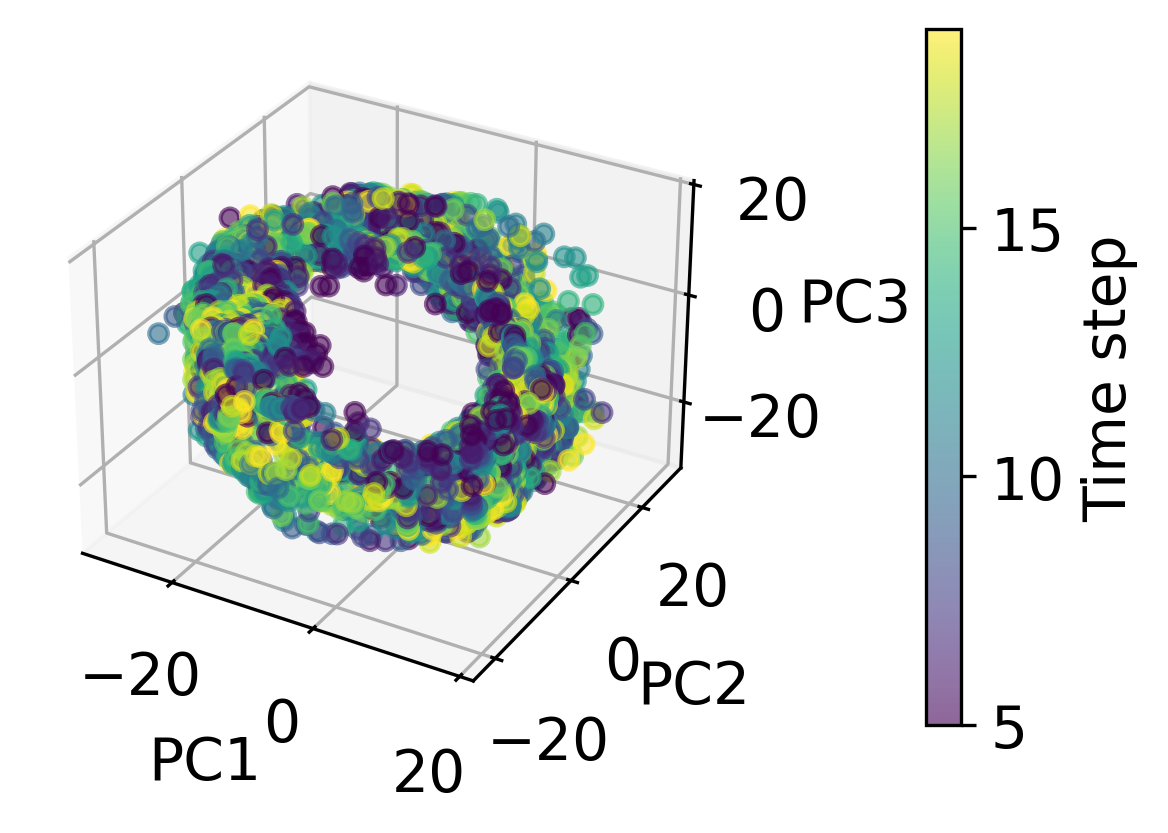

In [ ]:
%matplotlib inline
plt.close('all')
plt.rcParams.update({'font.size': 14})

# Create graphics and 3D axes
fig = plt.figure(figsize=(6, 3), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Show data after initial transient (after 5 steps)
trajectory = trajectory[5:]
neural_lowdim = neural_lowdim[1000:]

# Time steps
t = np.arange(trajectory.shape[0]) + 5  # After 5 steps
t_flat = np.repeat(t, trajectory.shape[1])  # Flatten time variable

# Flatten data
trajectory_flat = trajectory.reshape(-1, trajectory.shape[-1])
neural_lowdim_flat = neural_lowdim

# Plot 3D scatter plot
sc = ax.scatter(neural_lowdim_flat[:, 0], 
        neural_lowdim_flat[:, 1], 
        neural_lowdim_flat[:, 2], 
        c=t_flat, 
        cmap='viridis', 
        alpha=0.6)

# Add title and axis labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
# ax.view_init(elev=240, azim=60)  # Adjust viewing angle

# Add color bar
cbar = plt.colorbar(sc, ax=ax, pad=0.12, label='Time step')

# Adjust layout
# plt.savefig('plot.png', dpi=300, bbox_inches='tight', pad_inches=0.6)
plt.tight_layout()
plt.show()